In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import os
import pickle

In [3]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#pd.reset_option('display.max_rows')

In [4]:
df_merged = pd.read_csv('../../data/processed/pollution_process.csv')
df_merged['Measurement date'] = pd.to_datetime(df_merged['Measurement date'], errors='coerce')

df_filtered  = df_merged[df_merged['Instrument status'] == 0].copy()

In [5]:
df_SO2 = df_filtered[(df_filtered['Station code'] == 206) & (df_filtered['Item name'] == 'SO2')]
df_NO2 = df_filtered[(df_filtered['Station code'] == 211) & (df_filtered['Item name'] == 'NO2')]
df_O3 = df_filtered[(df_filtered['Station code'] == 217) & (df_filtered['Item name'] == 'O3')]
df_CO = df_filtered[(df_filtered['Station code'] == 219) & (df_filtered['Item name'] == 'CO')]
df_PM10 = df_filtered[(df_filtered['Station code'] == 225) & (df_filtered['Item name'] == 'PM10')]
df_PM2_5 = df_filtered[(df_filtered['Station code'] == 228) & (df_filtered['Item name'] == 'PM2.5')]

C:\Users\User\AppData\Local\Temp\ipykernel_10832\1363344809.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  serie_diaria_2021 = serie_diaria_2021.fillna(method='ffill').fillna(method='bfill')
C:\Users\User\AppData\Local\Temp\ipykernel_10832\1363344809.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  serie_diaria_2022 = serie_diaria_2022.fillna(method='ffill').fillna(method='bfill')


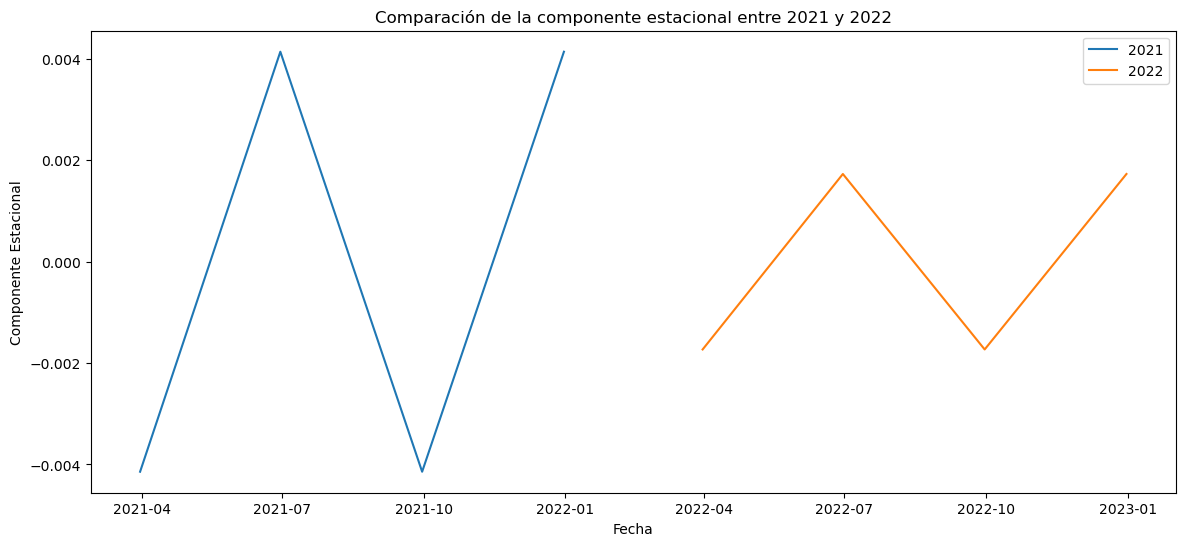

In [6]:
# Comprobamos que la estacionalidad es estable de año a año

df_O3 = df_O3.set_index('Measurement date')

# Filtrar datos por año, por ejemplo, 2021 y 2022:
df_2021 = df_O3[df_O3['year'] ==2021]
df_2022 = df_O3[df_O3['year'] ==2022]

# Resample a diario y calcular la media
serie_diaria_2021 = df_2021['Measurement value'].resample('q').mean()
serie_diaria_2022 = df_2022['Measurement value'].resample('q').mean()

# Imputar missing values, por ejemplo con forward fill, y en caso de que queden nulos, backward fill
serie_diaria_2021 = serie_diaria_2021.fillna(method='ffill').fillna(method='bfill')
serie_diaria_2022 = serie_diaria_2022.fillna(method='ffill').fillna(method='bfill')

# Ahora aplicar la descomposición
decomp_2021 = seasonal_decompose(serie_diaria_2021, model='additive', period= 2)
decomp_2022 = seasonal_decompose(serie_diaria_2022, model='additive', period= 2)

# Graficar la componente estacional de cada año para comparar
plt.figure(figsize=(14,6))
plt.plot(decomp_2021.seasonal.index, decomp_2021.seasonal, label='2021')
plt.plot(decomp_2022.seasonal.index, decomp_2022.seasonal, label='2022')
plt.xlabel("Fecha")
plt.ylabel("Componente Estacional")
plt.title("Comparación de la componente estacional entre 2021 y 2022")
plt.legend()
plt.show()

df_O3 = df_O3.reset_index()


In [7]:
def add_time_features(df):
    df = df.sort_values(by = 'Measurement date')
    # Establecemos 'Measurement date' como índice para poder usar ventanas móviles
    df = df.set_index('Measurement date')
    
    # Creamos features para una hora atrás, 4 horas atrás, 8 horas atrás y 12 horas atrás
    df['lag_1'] = df['Measurement value'].shift(1) 
    df['rolling_mean_4'] = df['Measurement value'].rolling(window=4).mean()
    df['rolling_mean_8'] = df['Measurement value'].rolling(window=8).mean()
    df['rolling_mean_12'] = df['Measurement value'].rolling(window=12).mean()
    
    # Restablecer el índice para trabajar cómodamente con el DataFrame
    df = df.reset_index()
    
    df['hourly_season_avg'] = df.groupby(['season', 'hour'])['Measurement value'].transform('mean')
    df['hourly_week_avg'] = df.groupby(['week_of_year', 'hour'])['Measurement value'].transform('mean')
    df['hourly_month_avg'] = df.groupby(['month', 'hour'])['Measurement value'].transform('mean')
    
    # Calcular last_week_hourly_mean como el hourly_week_avg de la semana anterior para la misma hora
    df['last_week_hourly_mean'] = df.groupby('hour')['hourly_week_avg'].transform(lambda x: x.shift(1))
    
    # Calcular last_month_hourly_mean como el hourly_month_avg del mes anterior para la misma hora
    df['last_month_hourly_mean'] = df.groupby('hour')['hourly_month_avg'].transform(lambda x: x.shift(1))
    
    df = df.set_index('Measurement date')
    
    # En caso de que aún queden nulos (por ejemplo, al inicio de la serie), imputamos con la media de la hora
    df['lag_1'] = df['lag_1'].fillna(df['hourly_week_avg'])
    df['rolling_mean_4'] = df['rolling_mean_4'].fillna(df['hourly_week_avg'])
    df['rolling_mean_8'] = df['rolling_mean_8'].fillna(df['hourly_week_avg'])
    df['rolling_mean_12'] = df['rolling_mean_12'].fillna(df['hourly_week_avg'])
    df['last_week_hourly_mean'] = df['last_week_hourly_mean'].fillna(df['hourly_week_avg'])
    df['last_month_hourly_mean'] =df['last_month_hourly_mean'].fillna(df['hourly_month_avg'])
    
    df = df.reset_index()
    
    return df

In [8]:
df_SO2 = add_time_features(df_SO2)
df_NO2 = add_time_features(df_NO2)
df_O3 = add_time_features(df_O3)
df_CO = add_time_features(df_CO)
df_PM10 = add_time_features(df_PM10)
df_PM2_5 = add_time_features(df_PM2_5)

In [9]:
df_SO2[(df_SO2['year'] == 2023) & (df_SO2['month'] == 4) & (df_SO2['week_of_year'] == 15)]

,Measurement date,hour,day,weekday,is_weekend,week_of_year,month,quarter,season,year,Station code,Item name,Item code,Measurement value,value_classification,Instrument status,lag_1,rolling_mean_4,rolling_mean_8,rolling_mean_12,hourly_season_avg,hourly_week_avg,hourly_month_avg,last_week_hourly_mean,last_month_hourly_mean
19043,2023-04-10 00:00:00,0,10,0,0,15,4,2,2,2023,206,SO2,0,0.002,0,0.0,0.002,0.00200,0.002000,0.002000,0.003502,0.003095,0.003233,0.002905,0.003233
19044,2023-04-10 01:00:00,1,10,0,0,15,4,2,2,2023,206,SO2,0,0.002,0,0.0,0.002,0.00200,0.002000,0.002000,0.003425,0.002905,0.003167,0.002952,0.003167
19045,2023-04-10 02:00:00,2,10,0,0,15,4,2,2,2023,206,SO2,0,0.002,0,0.0,0.002,0.00200,0.002000,0.002000,0.003399,0.003381,0.003311,0.003095,0.003311
19046,2023-04-10 03:00:00,3,10,0,0,15,4,2,2,2023,206,SO2,0,0.002,0,0.0,0.002,0.00200,0.002000,0.002000,0.003369,0.003190,0.003278,0.003143,0.003278
19047,2023-04-10 04:00:00,4,10,0,0,15,4,2,2,2023,206,SO2,0,0.002,0,0.0,0.002,0.00200,0.002000,0.002000,0.003245,0.002905,0.003067,0.002905,0.003067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19206,2023-04-16 19:00:00,19,16,6,1,15,4,2,2,2023,206,SO2,0,0.004,0,0.0,0.004,0.00400,0.003875,0.004167,0.003803,0.003714,0.003589,0.003714,0.003589
19207,2023-04-16 20:00:00,20,16,6,1,15,4,2,2,2023,206,SO2,0,0.004,0,0.0,0.004,0.00400,0.003875,0.004083,0.003713,0.003476,0.003411,0.003476,0.003411
19208,2023-04-16 21:00:00,21,16,6,1,15,4,2,2,2023,206,SO2,0,0.003,0,0.0,0.004,0.00375,0.003750,0.003917,0.003679,0.003143,0.003367,0.003143,0.003367
19209,2023-04-16 22:00:00,22,16,6,1,15,4,2,2,2023,206,SO2,0,0.003,0,0.0,0.003,0.00350,0.003625,0.003750,0.003561,0.003048,0.003322,0.003048,0.003322


In [10]:
df_SO2[(df_SO2['year'] == 2023) & (df_SO2['month'] == 4)  & (df_SO2['week_of_year'] == 16)]

,Measurement date,hour,day,weekday,is_weekend,week_of_year,month,quarter,season,year,Station code,Item name,Item code,Measurement value,value_classification,Instrument status,lag_1,rolling_mean_4,rolling_mean_8,rolling_mean_12,hourly_season_avg,hourly_week_avg,hourly_month_avg,last_week_hourly_mean,last_month_hourly_mean
19211,2023-04-17 00:00:00,0,17,0,0,16,4,2,2,2023,206,SO2,0,0.003,0,0.0,0.003,0.00300,0.003500,0.003583,0.003502,0.003000,0.003233,0.003095,0.003233
19212,2023-04-17 01:00:00,1,17,0,0,16,4,2,2,2023,206,SO2,0,0.003,0,0.0,0.003,0.00300,0.003375,0.003500,0.003425,0.002952,0.003167,0.002905,0.003167
19213,2023-04-17 02:00:00,2,17,0,0,16,4,2,2,2023,206,SO2,0,0.003,0,0.0,0.003,0.00300,0.003250,0.003417,0.003399,0.003048,0.003311,0.003381,0.003311
19214,2023-04-17 03:00:00,3,17,0,0,16,4,2,2,2023,206,SO2,0,0.003,0,0.0,0.003,0.00300,0.003125,0.003417,0.003369,0.002952,0.003278,0.003190,0.003278
19215,2023-04-17 04:00:00,4,17,0,0,16,4,2,2,2023,206,SO2,0,0.003,0,0.0,0.003,0.00300,0.003000,0.003333,0.003245,0.002857,0.003067,0.002905,0.003067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19371,2023-04-23 19:00:00,19,23,6,1,16,4,2,2,2023,206,SO2,0,0.005,0,0.0,0.004,0.00425,0.004375,0.004667,0.003803,0.003810,0.003589,0.003810,0.003589
19372,2023-04-23 20:00:00,20,23,6,1,16,4,2,2,2023,206,SO2,0,0.005,0,0.0,0.005,0.00450,0.004375,0.004583,0.003713,0.003476,0.003411,0.003476,0.003411
19373,2023-04-23 21:00:00,21,23,6,1,16,4,2,2,2023,206,SO2,0,0.004,0,0.0,0.005,0.00450,0.004250,0.004500,0.003679,0.003238,0.003367,0.003238,0.003367
19374,2023-04-23 22:00:00,22,23,6,1,16,4,2,2,2023,206,SO2,0,0.004,0,0.0,0.004,0.00450,0.004250,0.004417,0.003561,0.003190,0.003322,0.003190,0.003322


In [11]:
def outliers_tukey(df, col, lado_outliers, k=1.5):
    
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    ric = q3 - q1

    if lado_outliers == 'derecho':
        lim_l = df[col].min()
        lim_r = q3 + k * ric

    elif lado_outliers == 'izquierdo':
        lim_l = q1 - k * ric
        lim_r = df[col].max()

    elif lado_outliers == 'ambos':
        lim_l = q1 - k * ric
        lim_r = q3 + k * ric

    else: 
        print(f'No has indicado un lado válido para los outliers. Usa "derecho", "izquierdo", o "ambos".')
        
    porcentaje = df[df[col].between(lim_l, lim_r) | df[col].isna()].shape[0] / df.shape[0] * 100
    df = df[df[col].between(lim_l, lim_r) | df[col].isna()]
    #print(lim_l, lim_r)
    print(f'Se mantienen el {porcentaje:.2f}% de los datos en la columna {col} después de eliminar los outliers.')
    
    fig = plt.figure(figsize=(14, 6))
    gs = fig.add_gridspec(1, 2)
        
    ax1 = fig.add_subplot(gs[0, 0])
    sns.histplot(df[col], kde=True, ax=ax1)
    plt.axvline(lim_l, color='red')
    plt.axvline(lim_r, color='red')
    ax1.set_title(f'Histograma de {col}')
    ax1.set_xlabel(col)
        
    ax2 = fig.add_subplot(gs[0, 1])
    sns.boxplot(x=df[col], ax=ax2)
    plt.axvline(lim_l, color='red')
    plt.axvline(lim_r, color='red')
    ax2.set_title(f'Boxplot de {col}')
    ax2.set_xlabel(col)
        
    plt.tight_layout()
    plt.show()
    
    return df

In [12]:
def outliers_z(df, col, z=3):
        
    mean = df[col].mean()
    std = df[col].std()
    
    lim_l = mean - z*std
    lim_r = mean + z*std
    
    porcentaje = df[df[col].between(lim_l, lim_r) | df[col].isna()].shape[0] / df.shape[0] * 100
    
    df = df[df[col].between(lim_l, lim_r) | df[col].isna()]
    print(f'Se mantienen el {porcentaje:.2f}% de los datos en la columna {col} después de eliminar los outliers.')
    
    fig = plt.figure(figsize=(14, 6))
    gs = fig.add_gridspec(1, 2)
        
    ax1 = fig.add_subplot(gs[0, 0])
    sns.histplot(df[col], kde=True, ax=ax1)
    plt.axvline(lim_l, color='red')
    plt.axvline(lim_r, color='red')
    ax1.set_title(f'Histograma de {col}')
    ax1.set_xlabel(col)
        
    ax2 = fig.add_subplot(gs[0, 1])
    sns.boxplot(x=df[col], ax=ax2)
    plt.axvline(lim_l, color='red')
    plt.axvline(lim_r, color='red')
    ax2.set_title(f'Boxplot de {col}')
    ax2.set_xlabel(col)
        
    plt.tight_layout()
    plt.show()
    
    return df

Se mantienen el 98.27% de los datos en la columna Measurement value después de eliminar los outliers.


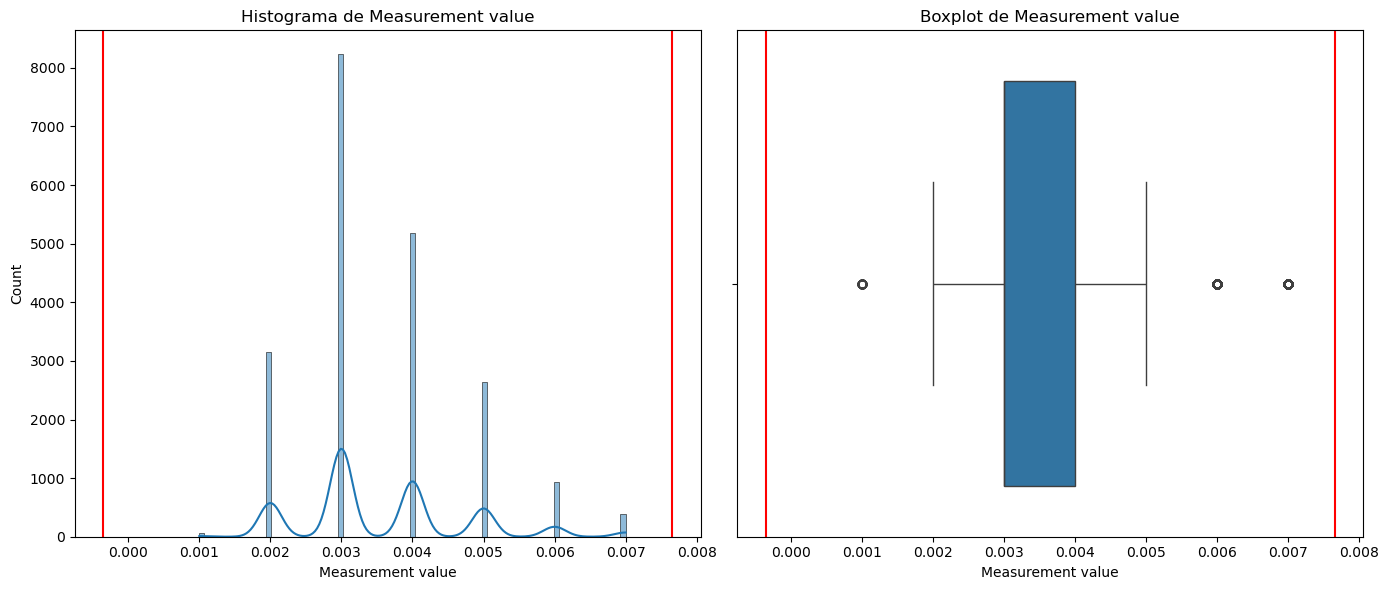

Se mantienen el 99.47% de los datos en la columna Measurement value después de eliminar los outliers.


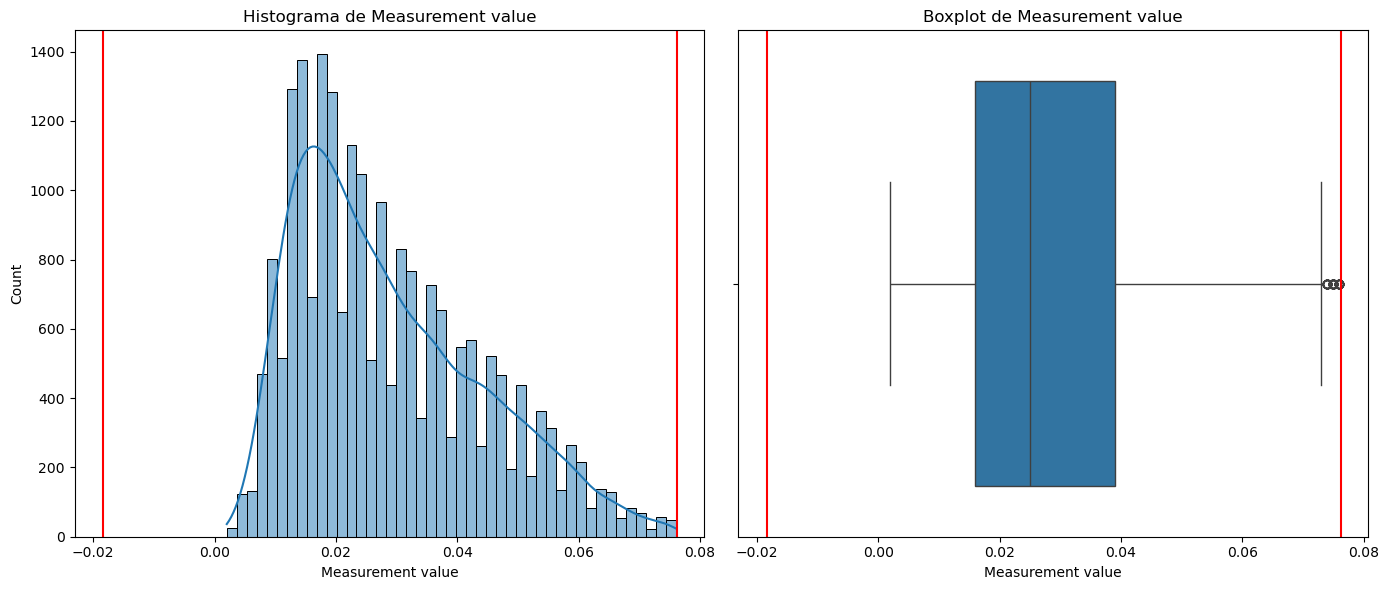

Se mantienen el 98.07% de los datos en la columna Measurement value después de eliminar los outliers.


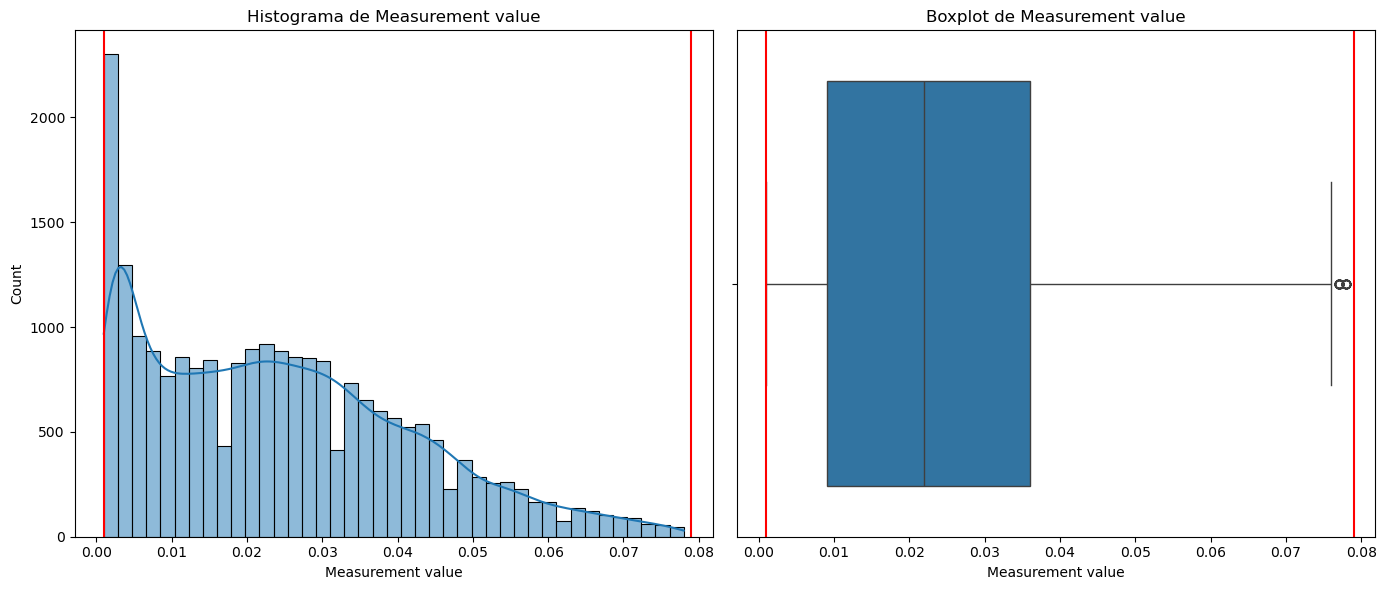

Se mantienen el 97.63% de los datos en la columna Measurement value después de eliminar los outliers.


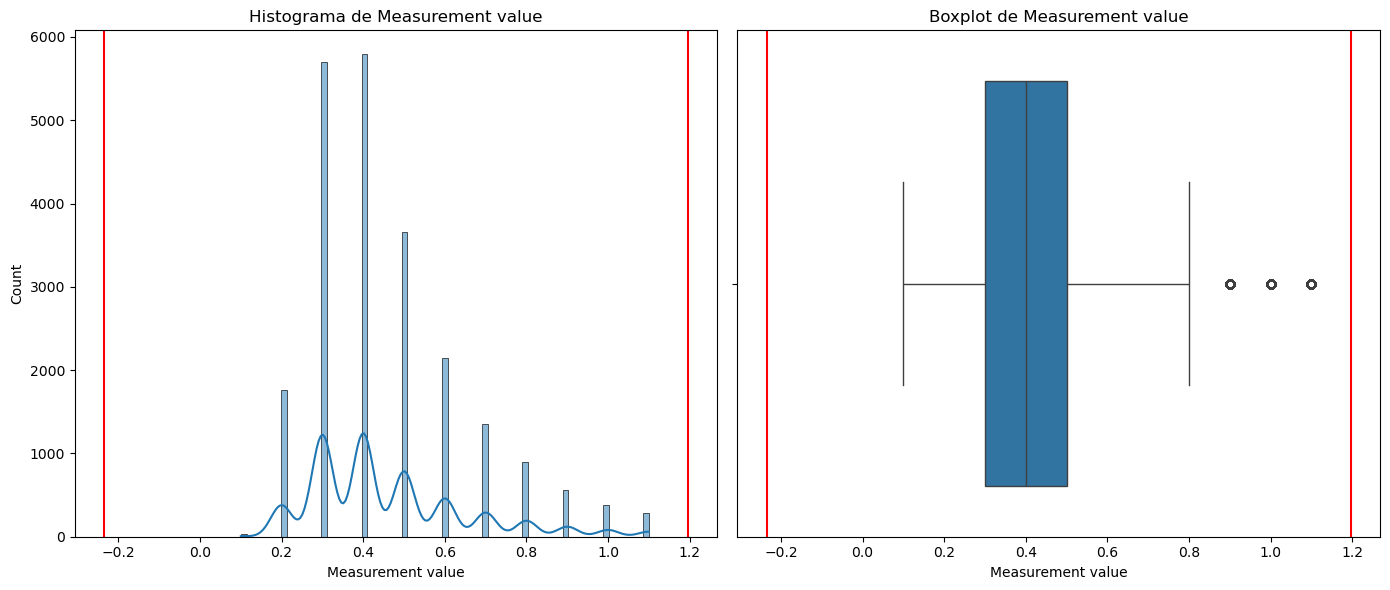

Se mantienen el 98.41% de los datos en la columna Measurement value después de eliminar los outliers.


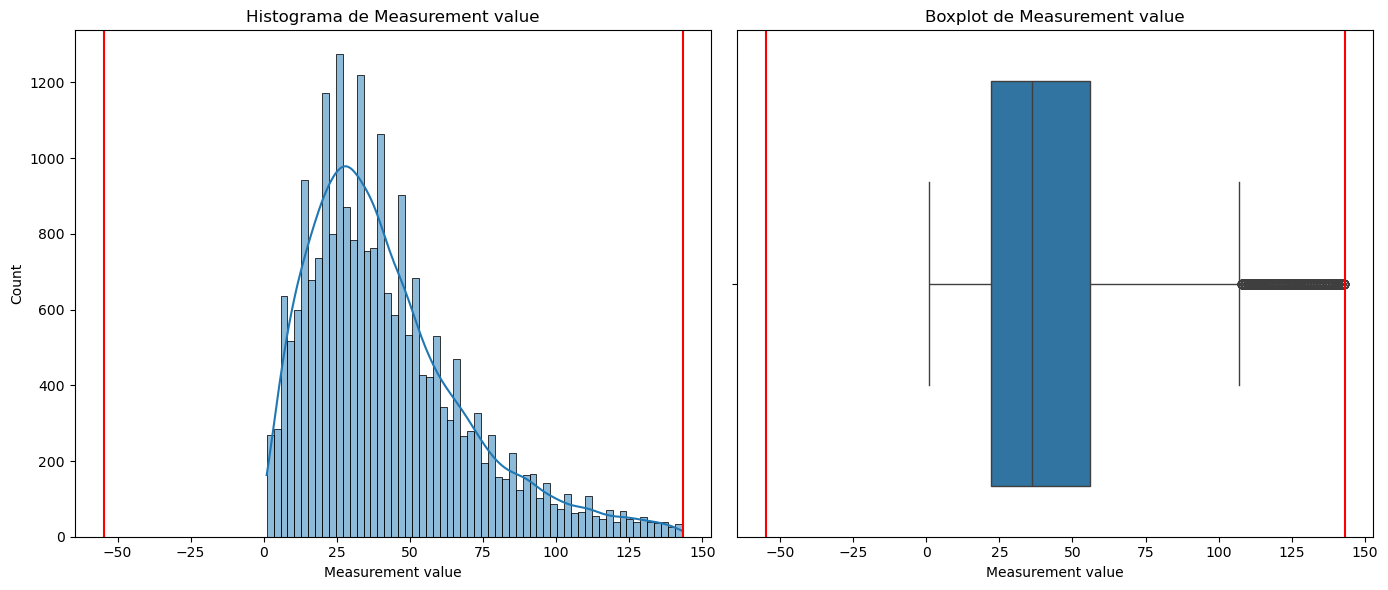

Se mantienen el 97.89% de los datos en la columna Measurement value después de eliminar los outliers.


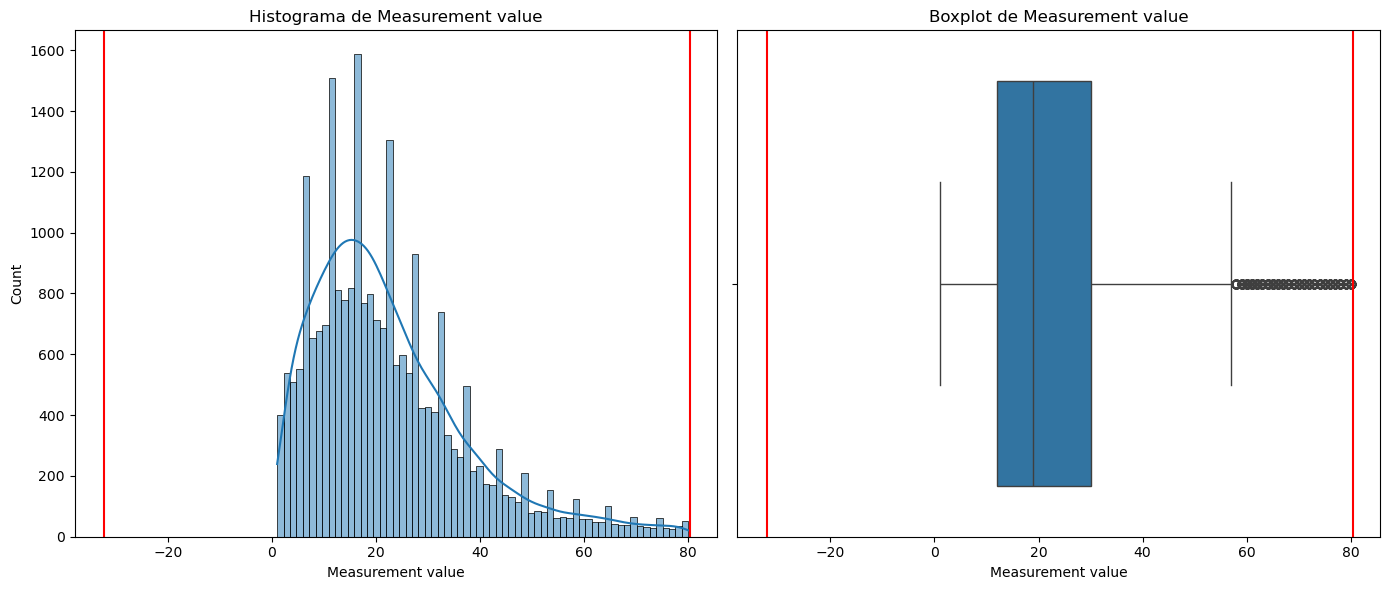

In [13]:
df_SO2 = outliers_z(df_SO2, 'Measurement value')
df_NO2 = outliers_z(df_NO2, 'Measurement value')
df_O3 = outliers_tukey(df_O3, 'Measurement value', 'derecho')
df_CO = outliers_z(df_CO, 'Measurement value')
df_PM10 = outliers_z(df_PM10, 'Measurement value')
df_PM2_5 = outliers_z(df_PM2_5, 'Measurement value')

In [14]:
def season_encoding(df):
    
    df['sin_season'] = np.sin(2 * np.pi * (df['season'] - 1) / 4)
    df['cos_season'] = np.cos(2 * np.pi * (df['season'] - 1) / 4)
    df['sin_month'] = np.sin(2 * np.pi * (df['month'] ) / 12)
    df['cos_month'] = np.cos(2 * np.pi * (df['month'] ) / 12)
    
    df = df.drop(columns=['season'])
    df = df.drop(columns=['month'])
    
    return df

In [15]:
df_SO2 = df_SO2.drop(columns=['Item name', 'Item code', 'Station code', 'value_classification', 'Instrument status', 'quarter', 'is_weekend', 'weekday', 'day', 'hourly_week_avg', 'hourly_month_avg' ])
df_NO2 = df_NO2.drop(columns=['Item name', 'Item code', 'Station code', 'value_classification', 'Instrument status', 'quarter', 'is_weekend', 'weekday', 'day', 'hourly_week_avg', 'hourly_month_avg' ])
df_O3 = df_O3.drop(columns=['Item name', 'Item code', 'Station code', 'value_classification', 'Instrument status', 'quarter', 'is_weekend', 'weekday', 'day', 'hourly_week_avg', 'hourly_month_avg' ])
df_CO = df_CO.drop(columns=['Item name', 'Item code', 'Station code', 'value_classification', 'Instrument status', 'quarter', 'is_weekend', 'weekday', 'day', 'hourly_week_avg', 'hourly_month_avg' ])
df_PM10 = df_PM10.drop(columns=['Item name', 'Item code', 'Station code', 'value_classification', 'Instrument status', 'quarter', 'is_weekend', 'weekday', 'day', 'hourly_week_avg', 'hourly_month_avg' ])
df_PM2_5 = df_PM2_5.drop(columns=['Item name', 'Item code', 'Station code', 'value_classification', 'Instrument status', 'quarter', 'is_weekend', 'weekday', 'day', 'hourly_week_avg', 'hourly_month_avg' ])

In [16]:
df_SO2 = season_encoding(df_SO2)
df_NO2 = season_encoding(df_NO2)
df_O3 = season_encoding(df_O3)
df_CO = season_encoding(df_CO)
df_PM10 = season_encoding(df_PM10)
df_PM2_5 = season_encoding(df_PM2_5)

In [17]:
def scale_data(df, identifier):
    
    dates = df["Measurement date"].reset_index(drop=True)
    x = df.drop(columns=["Measurement date", "Measurement value"]) 
    y = df['Measurement value']
    
    cols_x = list(x.columns)
    
    # Creamos los scalers, escalamos los datos y guardamos el scaler en un archivo .pickle
    x_scaler = MinMaxScaler()
    x = x_scaler.fit_transform(x)
    nombre_pickle_x = f"{identifier}_x_scaler.pkl"
    with open(nombre_pickle_x, "wb") as file:
        pickle.dump(x_scaler, file)

    y_scaler = MinMaxScaler()
    y = y_scaler.fit_transform(y.values.reshape(-1, 1))
    nombre_pickle_y = f"{identifier}_y_scaler.pkl"
    with open(nombre_pickle_y, "wb") as file:
        pickle.dump(y_scaler, file)
        
    x_df = pd.DataFrame(x, columns=cols_x) 
    y_df = pd.DataFrame(y, columns=['Measurement value'])

    df_escalado = pd.concat([dates, x_df, y_df], axis=1)
        
    return df_escalado

In [18]:
df_SO2_scaled = scale_data(df_SO2, 'SO2')
df_NO2_scaled = scale_data(df_NO2, 'NO2')
df_O3_scaled = scale_data(df_O3, 'O3')
df_CO_scaled = scale_data(df_CO, 'CO')
df_PM10_scaled = scale_data(df_PM10, 'PM10')
df_PM2_5_scaled = scale_data(df_PM2_5, 'PM2.5')

In [19]:
df_SO2_scaled.to_csv('../../data/processed/SO2_process.csv', index = False)
df_NO2_scaled.to_csv('../../data/processed/NO2_process.csv', index = False)
df_O3_scaled.to_csv('../../data/processed/O3_process.csv', index = False)
df_CO_scaled.to_csv('../../data/processed/CO_process.csv', index = False)
df_PM10_scaled.to_csv('../../data/processed/PM10_process.csv', index = False)
df_PM2_5_scaled.to_csv('../../data/processed/PM2_5_process.csv', index = False)